In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (30., 30.)
#%matplotlib inline

In [2]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [30]:
def get_ERA5(era_pl, era_srfc, indic):
    
    dic = {}

    dic['q_col'] = []
    dic['u_col'] = []
    dic['r_col'] = []
    dic['v_col'] = []
    ### single values
    dic['tcwv'] = []
    dic['CAPE'] = []
    dic['dates'] = []
    dic['tmin'] = []
    dic['tmean'] = []
    dic['t10'] = []
    dic['area'] = []
    dic['area70'] = []
    dic['lat'] = []
    dic['lon'] = []
    dic['u925'] = []
    dic['u650'] = []
    dic['q925'] = []
    dic['q700'] = []
    
    for id, date in enumerate(indic.date):
        
        print('Doing', date)
        

#         getera_pl =np.where((era_pl['time.day']==(indic['date'])[id].day) & (era_pl['time.month']==indic.month[id]) 
#                             & (era_pl['time.year']==indic.year[id]) & (era_pl['time.hour']==12))
        
#         getera_sf =np.where((era_srfc['time.day']==(indic['date'])[id].day)  & (era_srfc['time.year']==indic.year[id]) 
#                             & (era_srfc['time.month']==indic.month[id]) & (era_srfc['time.hour']==12))

        time = str(date.year)+str(date.month).zfill(2)+str(date.day).zfill(2)+'T12'

        try:
            era_day_pl = era_pl.sel(time=time).isel(time=0)
        except (TypeError, IndexError, KeyError):
            print('Era missing:', date)
            for k in dic.keys():
                dic[k].append(np.nan)
            continue

        era_day_sf = era_srfc.sel(time=time).isel(time=0)

        elat = indic.clat[id]
        elon = indic.clon[id]
        dic['dates'].append(date)
        dic['lat'].append(elat)
        dic['lon'].append(elon)
        
        point = era_day_sf.sel(latitude=elat, longitude=elon, method='nearest')
        
        posx = int(np.where(era_day_sf.longitude == point.longitude)[0])
        posy = int(np.where(era_day_sf.latitude == point.latitude)[0])

        dic['u925'].append(np.asscalar((era_day_pl['u'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).sel(level=925).mean().values)))
        dic['u650'].append(np.asscalar((era_day_pl['u'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).sel( level=650).mean().values)))
        dic['q925'].append(np.asscalar((era_day_pl['q'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).sel( level=925).mean().values)))
        dic['q700'].append(np.asscalar((era_day_pl['q'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).sel( level=700).mean().values)))
        dic['CAPE'].append(np.asscalar((era_day_sf['cape'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean().values)))
        dic['tcwv'].append(np.asscalar((era_day_sf['tcwv'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean().values)))
                          
        dic['q_col'].append((era_day_pl['q'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean(['latitude', 'longitude']).values))
        dic['u_col'].append((era_day_pl['u'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean(['latitude', 'longitude']).values))
        dic['r_col'].append((era_day_pl['r'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean(['latitude', 'longitude']).values))
        dic['v_col'].append((era_day_pl['v'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean(['latitude', 'longitude']).values))
        
        dic['tmin'].append(indic.tmin[id])
        dic['tmean'].append(indic.tmean[id])
        dic['t10'].append(indic.t10[id])
        dic['area'].append(indic.area[id])
        dic['area70'].append((indic['70area'])[id])
    dic['level'] = era_pl.level.values
    
    return dic

In [31]:
def get_ERA5_clim(era_pl_clim, era_srfc_clim, indic):
    
    dic = {}

    dic['q_col'] = []
    dic['u_col'] = []
    dic['r_col'] = []
    dic['v_col'] = []
    ### single values
    dic['tcwv'] = []
    dic['CAPE'] = []
    dic['dates'] = []
    dic['tmin'] = []
    dic['tmean'] = []
    dic['t10'] = []
    dic['area'] = []
    dic['area70'] = []
    dic['lat'] = []
    dic['lon'] = []
    dic['u925'] = []
    dic['u650'] = []
    dic['q925'] = []
    dic['q700'] = []
    
    for id, date in enumerate(indic.date):
        
        print('Doing', date)


        time = str(date.year)+'-'+str(date.month)+'-'+'12'

        try:
            era_day_pl = era_pl_clim.sel(ymonth=time)
        except (TypeError, IndexError, KeyError):
            print('Era missing:', date)
            for k in dic.keys():
                dic[k].append(np.nan)
            continue

        era_day_sf = era_srfc_clim.sel(ymonth=time)

        elat = indic.clat[id]
        elon = indic.clon[id]
        dic['dates'].append(date)
        dic['lat'].append(elat)
        dic['lon'].append(elon)
        
        point = era_day_sf.sel(latitude=elat, longitude=elon, method='nearest')
        
        posx = int(np.where(era_day_sf.longitude == point.longitude)[0])
        posy = int(np.where(era_day_sf.latitude == point.latitude)[0])

        dic['u925'].append(np.asscalar((era_day_pl['u'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).sel(level=925).mean().values)))
        dic['u650'].append(np.asscalar((era_day_pl['u'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).sel( level=650).mean().values)))
        dic['q925'].append(np.asscalar((era_day_pl['q'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).sel( level=925).mean().values)))
        dic['q700'].append(np.asscalar((era_day_pl['q'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).sel( level=700).mean().values)))
        dic['CAPE'].append(np.asscalar((era_day_sf['cape'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean().values)))
        dic['tcwv'].append(np.asscalar((era_day_sf['tcwv'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean().values)))
                          
        dic['q_col'].append((era_day_pl['q'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean(['latitude', 'longitude']).values))
        dic['u_col'].append((era_day_pl['u'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean(['latitude', 'longitude']).values))
        dic['r_col'].append((era_day_pl['r'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean(['latitude', 'longitude']).values))
        dic['v_col'].append((era_day_pl['v'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean(['latitude', 'longitude']).values))
        
        dic['tmin'].append(indic.tmin[id])
        dic['tmean'].append(indic.tmean[id])
        dic['t10'].append(indic.t10[id])
        dic['area'].append(indic.area[id])
        dic['area70'].append((indic['70area'])[id])
    dic['level'] = era_pl_clim.level.values
    
    return dic

In [4]:
pdf = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA.p', 'rb'))

In [5]:
pdf_march = pdf.where((pdf.clat>=4.5) & (pdf.clat<=8.5) & (pdf.clon>=-12) & (pdf.clon<=12) &
(pdf.month == 3) & (pdf.year >=2000) & (pdf.year <=2012))
pdf_march = pdf_march.dropna()

In [6]:
pdf_oct = pdf.where((pdf.clat>=4.5) & (pdf.clat<=8.5) & (pdf.clon>=-12) & (pdf.clon<=12) &
(pdf.month == 10) & (pdf.year >=2000) & (pdf.year <=2012))
pdf_oct = pdf_oct.dropna()

In [16]:
era_pl = xr.open_mfdataset('/home/ck/DIR/mymachine/ERA5/pressure_levels/*.nc')
era_srfc = xr.open_mfdataset('/home/ck/DIR/mymachine/ERA5/surface/*.nc')

In [36]:
era_pl['ymonth'] = ('time', [str(y)+'-'+str(m)+'-'+str(h) for (y,m,h) in zip(era_pl['time.year'].values,era_pl['time.month'].values,era_pl['time.hour'].values)])
grouped='ymonth'
era_pl_mean =  era_pl.groupby(grouped).mean(dim='time')

In [37]:
era_srfc['ymonth'] = ('time', [str(y)+'-'+str(m)+'-'+str(h) for (y,m,h) in zip(era_srfc['time.year'].values,era_srfc['time.month'].values,era_srfc['time.hour'].values)])
grouped='ymonth'
era_srfc_mean =  era_srfc.groupby(grouped).mean(dim='time')

In [9]:
era_pl_box = era_pl.sel(latitude=slice(7.5,4.5), longitude=slice(-12,12))

In [52]:
q_clim_march = era_pl_box['q'][(era_pl_box['time.hour']==12)&(era_pl_box['time.month']==3)].mean(['latitude', 'longitude','time'])
u_clim_march = era_pl_box['u'][(era_pl_box['time.hour']==12)&(era_pl_box['time.month']==3)].mean(['latitude', 'longitude','time'])
v_clim_march = era_pl_box['v'][(era_pl_box['time.hour']==12)&(era_pl_box['time.month']==3)].mean(['latitude', 'longitude','time'])

In [53]:
q_clim_oct = era_pl_box['q'][(era_pl_box['time.hour']==12)&(era_pl_box['time.month']==10)].mean(['latitude', 'longitude','time'])
u_clim_oct = era_pl_box['u'][(era_pl_box['time.hour']==12)&(era_pl_box['time.month']==10)].mean(['latitude', 'longitude','time'])
v_clim_oct = era_pl_box['v'][(era_pl_box['time.hour']==12)&(era_pl_box['time.month']==10)].mean(['latitude', 'longitude','time'])

In [12]:
q_clim_oct.values

array([5.69420990e-05, 1.83720607e-04, 3.95964831e-04, 7.16251554e-04,
       1.18527003e-03, 1.93428551e-03, 3.03512090e-03, 4.22707573e-03,
       5.09281689e-03, 5.88065572e-03, 7.07634445e-03, 8.71986430e-03,
       1.17519861e-02, 1.27799865e-02, 1.37435822e-02, 1.45613989e-02,
       1.52245937e-02, 1.58360358e-02, 1.65317673e-02], dtype=float32)

In [15]:
# era_out = get_ERA5(era_pl, era_srfc, pdf_march)
# pkl.dump(era_out,open(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_march.p', 'wb'))

In [27]:
# era_clim_out = get_ERA5_clim(era_pl_mean, era_srfc_mean, pdf_march)
# pkl.dump(era_clim_out,open(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_march_clim.p', 'wb'))

Doing 2000-03-01 18:00:00
Doing 2000-03-02 18:00:00
Doing 2000-03-04 18:00:00
Doing 2000-03-05 18:00:00
Doing 2000-03-05 18:00:00
Doing 2000-03-05 18:00:00
Doing 2000-03-05 18:00:00
Doing 2000-03-06 18:00:00
Doing 2000-03-06 18:00:00
Doing 2000-03-06 18:00:00
Doing 2000-03-06 18:00:00
Doing 2000-03-06 18:00:00
Doing 2000-03-07 18:00:00
Doing 2000-03-08 18:00:00
Doing 2000-03-08 18:00:00
Doing 2000-03-09 18:00:00
Doing 2000-03-11 18:00:00
Doing 2000-03-12 18:00:00
Doing 2000-03-14 18:00:00
Doing 2000-03-14 18:00:00
Doing 2000-03-15 18:00:00
Doing 2000-03-15 18:00:00
Doing 2000-03-15 18:00:00
Doing 2000-03-15 18:00:00
Doing 2000-03-16 18:00:00
Doing 2000-03-16 18:00:00
Doing 2000-03-16 18:00:00
Doing 2000-03-16 18:00:00
Doing 2000-03-16 18:00:00
Doing 2000-03-16 18:00:00
Doing 2000-03-17 18:00:00
Doing 2000-03-17 18:00:00
Doing 2000-03-17 18:00:00
Doing 2000-03-17 18:00:00
Doing 2000-03-17 18:00:00
Doing 2000-03-17 18:00:00
Doing 2000-03-18 18:00:00
Doing 2000-03-18 18:00:00
Doing 2000-0

Doing 2002-03-07 18:00:00
Doing 2002-03-07 18:00:00
Doing 2002-03-07 18:00:00
Doing 2002-03-07 18:00:00
Doing 2002-03-07 18:00:00
Doing 2002-03-08 18:00:00
Doing 2002-03-08 18:00:00
Doing 2002-03-08 18:00:00
Doing 2002-03-08 18:00:00
Doing 2002-03-08 18:00:00
Doing 2002-03-08 18:00:00
Doing 2002-03-09 18:00:00
Doing 2002-03-09 18:00:00
Doing 2002-03-09 18:00:00
Doing 2002-03-09 18:00:00
Doing 2002-03-09 18:00:00
Doing 2002-03-10 18:00:00
Doing 2002-03-10 18:00:00
Doing 2002-03-10 18:00:00
Doing 2002-03-10 18:00:00
Doing 2002-03-10 18:00:00
Doing 2002-03-11 18:00:00
Doing 2002-03-11 18:00:00
Doing 2002-03-11 18:00:00
Doing 2002-03-12 18:00:00
Doing 2002-03-12 18:00:00
Doing 2002-03-12 18:00:00
Doing 2002-03-13 18:00:00
Doing 2002-03-13 18:00:00
Doing 2002-03-13 18:00:00
Doing 2002-03-13 18:00:00
Doing 2002-03-15 18:00:00
Doing 2002-03-15 18:00:00
Doing 2002-03-15 18:00:00
Doing 2002-03-15 18:00:00
Doing 2002-03-15 18:00:00
Doing 2002-03-15 18:00:00
Doing 2002-03-15 18:00:00
Doing 2002-0

Doing 2004-03-29 18:00:00
Doing 2004-03-29 18:00:00
Doing 2004-03-29 18:00:00
Doing 2004-03-29 18:00:00
Doing 2004-03-29 18:00:00
Doing 2004-03-29 18:00:00
Doing 2004-03-30 18:00:00
Doing 2004-03-30 18:00:00
Doing 2004-03-30 18:00:00
Doing 2004-03-31 18:00:00
Doing 2004-03-31 18:00:00
Doing 2004-03-31 18:00:00
Doing 2004-03-31 18:00:00
Doing 2004-03-31 18:00:00
Doing 2004-03-31 18:00:00
Doing 2005-03-01 18:00:00
Doing 2005-03-01 18:00:00
Doing 2005-03-01 18:00:00
Doing 2005-03-02 18:00:00
Doing 2005-03-02 18:00:00
Doing 2005-03-02 18:00:00
Doing 2005-03-02 18:00:00
Doing 2005-03-02 18:00:00
Doing 2005-03-02 18:00:00
Doing 2005-03-02 18:00:00
Doing 2005-03-02 18:00:00
Doing 2005-03-03 18:00:00
Doing 2005-03-03 18:00:00
Doing 2005-03-03 18:00:00
Doing 2005-03-04 18:00:00
Doing 2005-03-05 18:00:00
Doing 2005-03-05 18:00:00
Doing 2005-03-05 18:00:00
Doing 2005-03-05 18:00:00
Doing 2005-03-05 18:00:00
Doing 2005-03-06 18:00:00
Doing 2005-03-06 18:00:00
Doing 2005-03-06 18:00:00
Doing 2005-0

Doing 2006-03-29 18:00:00
Doing 2006-03-30 18:00:00
Doing 2006-03-30 18:00:00
Doing 2006-03-30 18:00:00
Doing 2006-03-30 18:00:00
Doing 2006-03-30 18:00:00
Doing 2006-03-30 18:00:00
Doing 2006-03-31 18:00:00
Doing 2006-03-31 18:00:00
Doing 2006-03-31 18:00:00
Doing 2007-03-01 18:00:00
Doing 2007-03-02 18:00:00
Doing 2007-03-05 18:00:00
Doing 2007-03-06 18:00:00
Doing 2007-03-06 18:00:00
Doing 2007-03-07 18:00:00
Doing 2007-03-07 18:00:00
Doing 2007-03-07 18:00:00
Doing 2007-03-08 18:00:00
Doing 2007-03-09 18:00:00
Doing 2007-03-09 18:00:00
Doing 2007-03-09 18:00:00
Doing 2007-03-09 18:00:00
Doing 2007-03-10 18:00:00
Doing 2007-03-10 18:00:00
Doing 2007-03-10 18:00:00
Doing 2007-03-10 18:00:00
Doing 2007-03-10 18:00:00
Doing 2007-03-10 18:00:00
Doing 2007-03-10 18:00:00
Doing 2007-03-10 18:00:00
Doing 2007-03-11 18:00:00
Doing 2007-03-11 18:00:00
Doing 2007-03-13 18:00:00
Doing 2007-03-13 18:00:00
Doing 2007-03-14 18:00:00
Doing 2007-03-14 18:00:00
Doing 2007-03-14 18:00:00
Doing 2007-0

Doing 2009-03-07 18:00:00
Doing 2009-03-08 18:00:00
Doing 2009-03-08 18:00:00
Doing 2009-03-08 18:00:00
Doing 2009-03-08 18:00:00
Doing 2009-03-09 18:00:00
Doing 2009-03-09 18:00:00
Doing 2009-03-09 18:00:00
Doing 2009-03-10 18:00:00
Doing 2009-03-10 18:00:00
Doing 2009-03-10 18:00:00
Doing 2009-03-10 18:00:00
Doing 2009-03-10 18:00:00
Doing 2009-03-10 18:00:00
Doing 2009-03-10 18:00:00
Doing 2009-03-10 18:00:00
Doing 2009-03-11 18:00:00
Doing 2009-03-11 18:00:00
Doing 2009-03-11 18:00:00
Doing 2009-03-12 18:00:00
Doing 2009-03-12 18:00:00
Doing 2009-03-12 18:00:00
Doing 2009-03-12 18:00:00
Doing 2009-03-12 18:00:00
Doing 2009-03-12 18:00:00
Doing 2009-03-13 18:00:00
Doing 2009-03-13 18:00:00
Doing 2009-03-13 18:00:00
Doing 2009-03-13 18:00:00
Doing 2009-03-13 18:00:00
Doing 2009-03-13 18:00:00
Doing 2009-03-13 18:00:00
Doing 2009-03-14 18:00:00
Doing 2009-03-14 18:00:00
Doing 2009-03-14 18:00:00
Doing 2009-03-14 18:00:00
Doing 2009-03-14 18:00:00
Doing 2009-03-14 18:00:00
Doing 2009-0

Doing 2011-03-12 18:00:00
Doing 2011-03-12 18:00:00
Doing 2011-03-12 18:00:00
Doing 2011-03-13 18:00:00
Doing 2011-03-13 18:00:00
Doing 2011-03-13 18:00:00
Doing 2011-03-13 18:00:00
Doing 2011-03-13 18:00:00
Doing 2011-03-13 18:00:00
Doing 2011-03-13 18:00:00
Doing 2011-03-13 18:00:00
Doing 2011-03-13 18:00:00
Doing 2011-03-13 18:00:00
Doing 2011-03-14 18:00:00
Doing 2011-03-14 18:00:00
Doing 2011-03-14 18:00:00
Doing 2011-03-14 18:00:00
Doing 2011-03-14 18:00:00
Doing 2011-03-14 18:00:00
Doing 2011-03-14 18:00:00
Doing 2011-03-14 18:00:00
Doing 2011-03-14 18:00:00
Doing 2011-03-14 18:00:00
Doing 2011-03-15 18:00:00
Doing 2011-03-15 18:00:00
Doing 2011-03-15 18:00:00
Doing 2011-03-15 18:00:00
Doing 2011-03-15 18:00:00
Doing 2011-03-15 18:00:00
Doing 2011-03-15 18:00:00
Doing 2011-03-15 18:00:00
Doing 2011-03-15 18:00:00
Doing 2011-03-16 18:00:00
Doing 2011-03-16 18:00:00
Doing 2011-03-16 18:00:00
Doing 2011-03-16 18:00:00
Doing 2011-03-16 18:00:00
Doing 2011-03-16 18:00:00
Doing 2011-0

In [7]:
era_march = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_march.p', 'rb'))
era_oct = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_oct.p', 'rb'))

In [8]:
era_march_clim = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_march_clim.p', 'rb'))
era_oct_clim = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_oct_clim.p', 'rb'))

{'CAPE': [1357.4210205078125,
  1441.404052734375,
  1418.51416015625,
  1240.24462890625,
  1368.3870849609375,
  922.5670776367188,
  605.9453735351562,
  1240.24462890625,
  1088.7320556640625,
  789.5051879882812,
  683.7396850585938,
  572.0053100585938,
  1240.24462890625,
  1242.15576171875,
  1335.4486083984375,
  1441.404052734375,
  1340.406982421875,
  1449.0731201171875,
  1449.0731201171875,
  1445.1448974609375,
  1491.0635986328125,
  975.8333129882812,
  711.099365234375,
  1357.4210205078125,
  727.279296875,
  421.4604187011719,
  1214.5467529296875,
  670.4484252929688,
  556.0072021484375,
  1163.1766357421875,
  1103.58935546875,
  494.8523254394531,
  625.2847290039062,
  612.7388305664062,
  773.7024536132812,
  1473.4739990234375,
  476.51519775390625,
  542.34619140625,
  93.39430236816406,
  418.27923583984375,
  476.3629455566406,
  72.9233169555664,
  1283.86083984375,
  469.388671875,
  305.06451416015625,
  427.3218078613281,
  428.1258239746094,
  942.004

In [9]:
level = era_march.pop('level')
level = era_oct.pop('level')

In [10]:
for k in era_march.keys():
    era_march[k] = era_march[k][0:1841]

In [11]:
for k in era_oct.keys():
    era_oct[k] = era_oct[k][0:2096]

In [12]:
print(np.array(era_oct['CAPE']).mean())
print(np.array(era_oct_clim['CAPE']).mean())

1063.4757279858334
959.3785168465058


In [13]:
print(np.array(era_march['CAPE']).mean())
print(np.array(era_march_clim['CAPE']).mean())

1237.0779014713798
1065.4395493295515


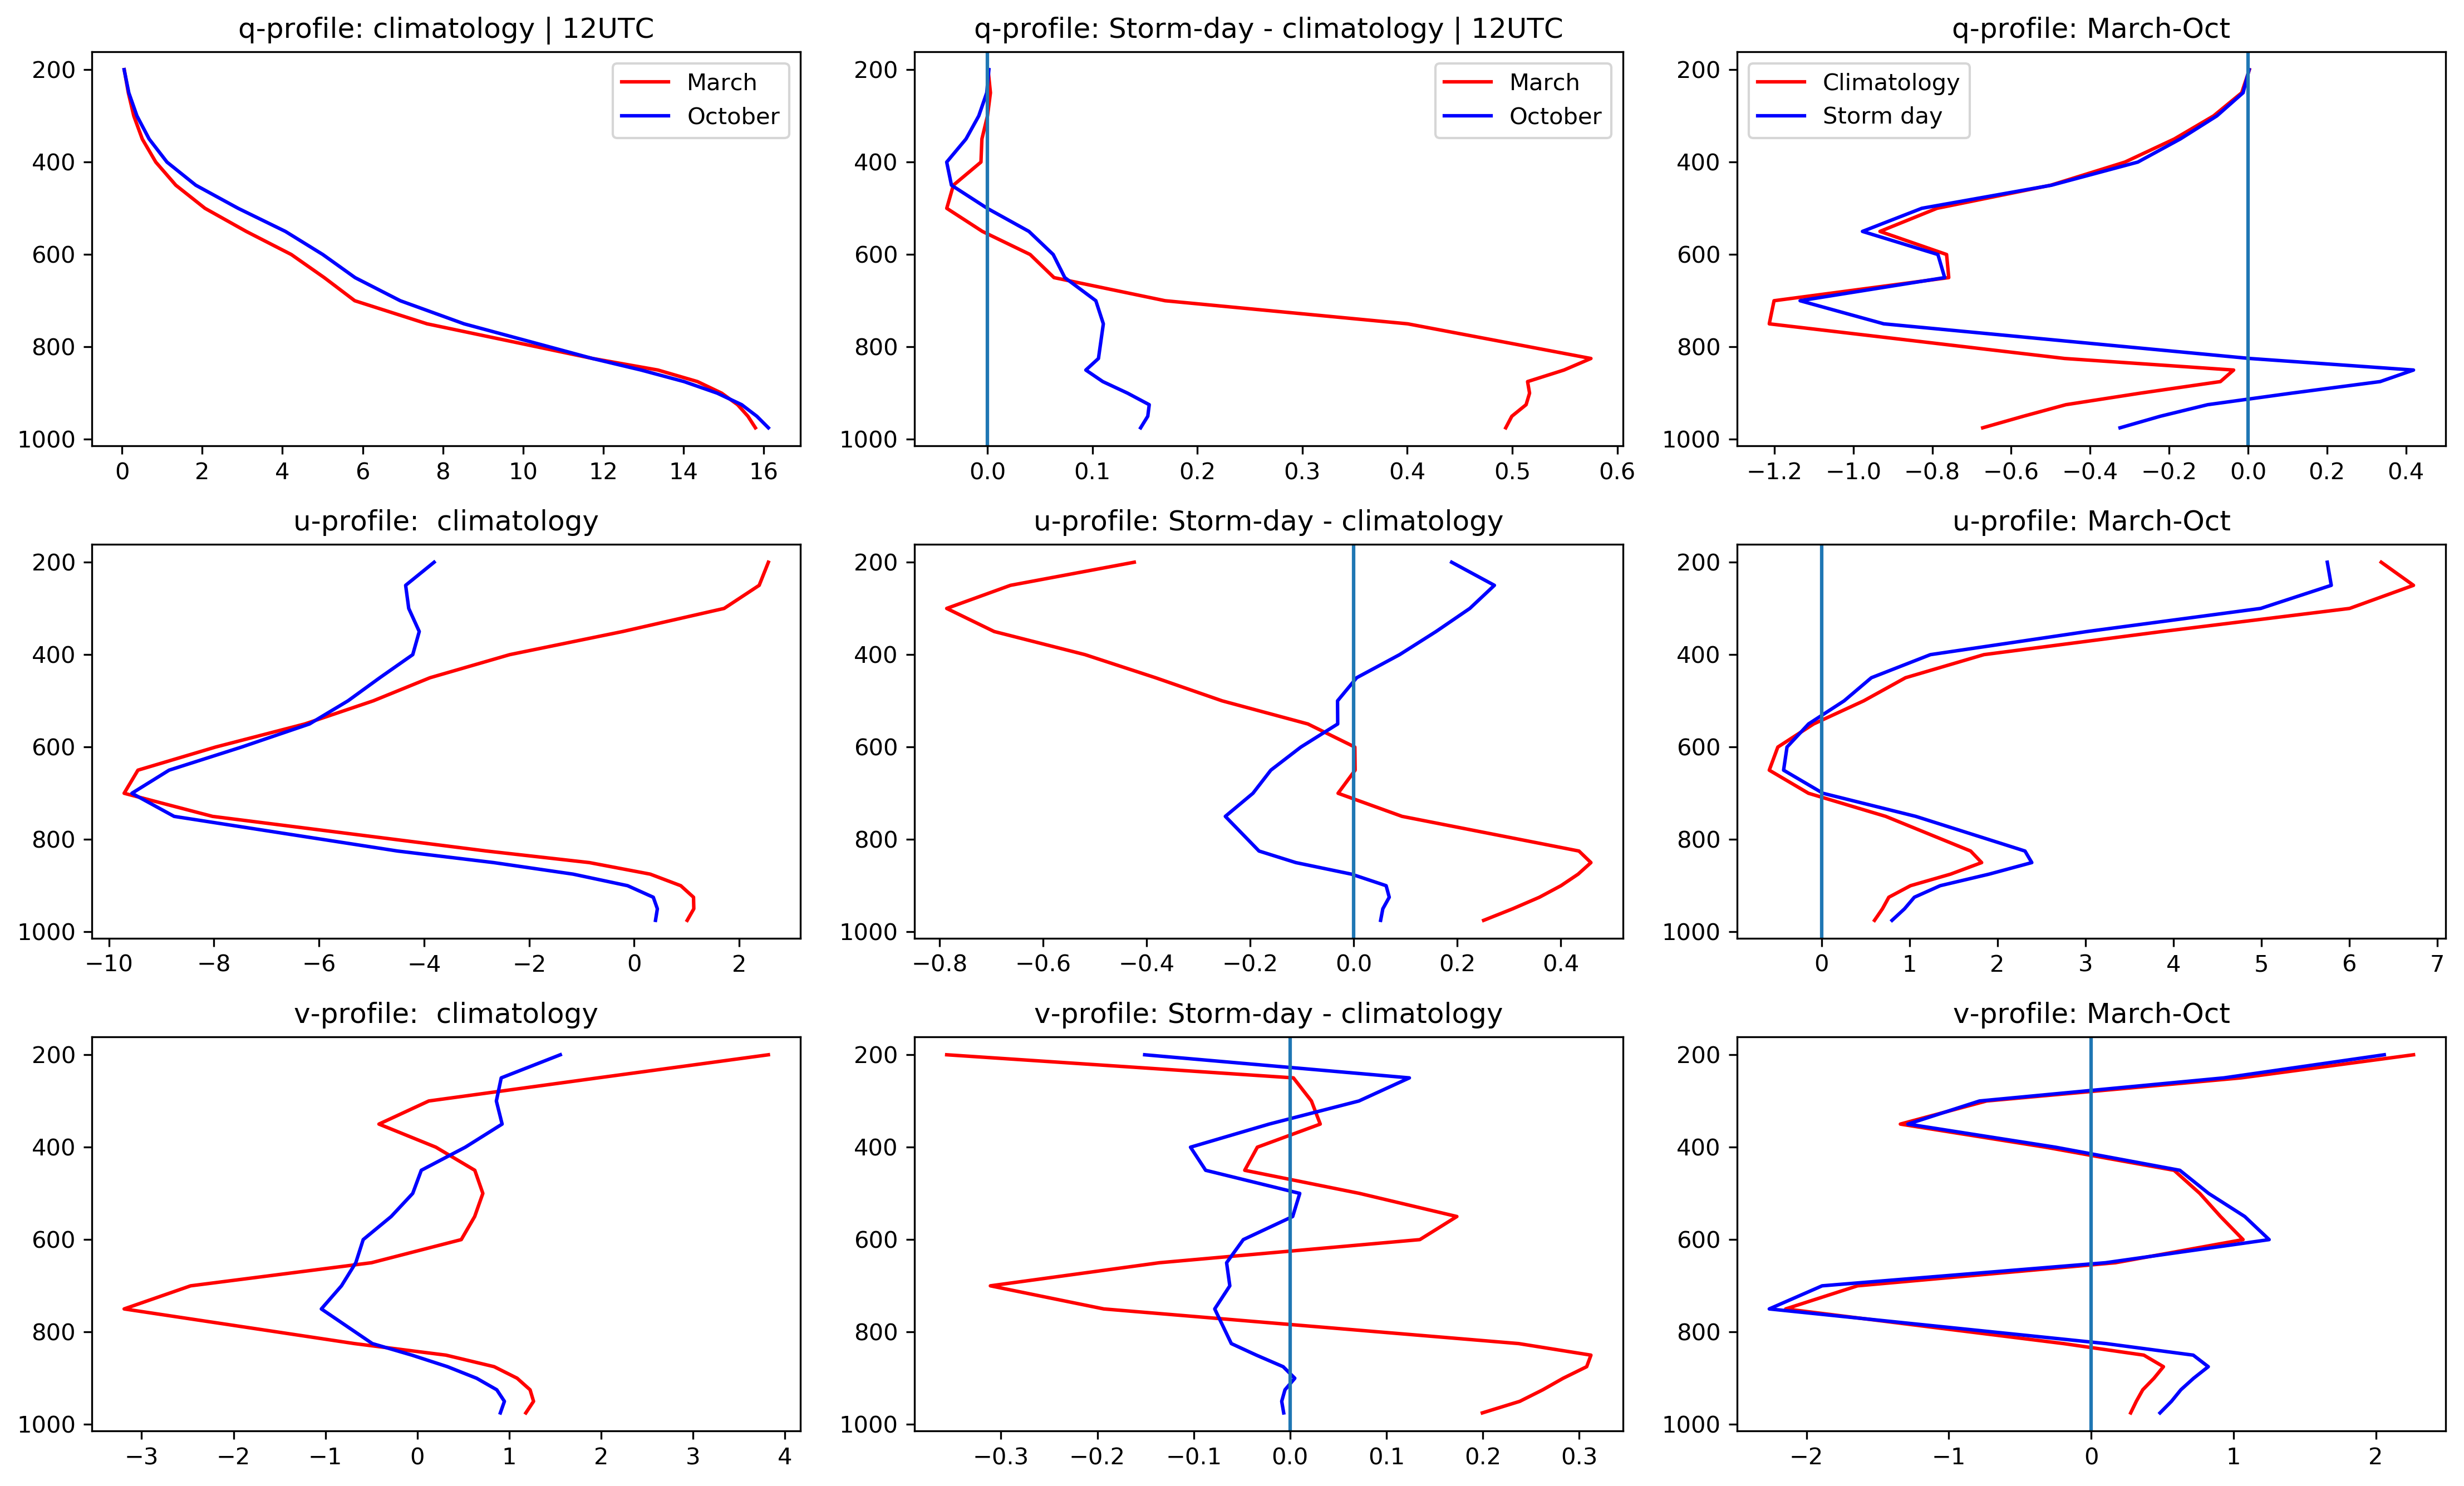

In [19]:
q_march =  np.array(era_march['q_col']).mean(axis=0)*1000 
q_oct =  np.array(era_oct['q_col']).mean(axis=0)*1000 
f = plt.figure(figsize=(15,9), dpi=300)
f.add_subplot(331)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: climatology | 12UTC')
plt.legend()

q_march =  np.array(era_march_clim['u_col']).mean(axis=0)
q_oct =  np.array(era_oct_clim['u_col']).mean(axis=0)
f.add_subplot(334)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile:  climatology')

q_march = np.array(era_march['q_col']).mean(axis=0)*1000 - np.array(era_march_clim['q_col']).mean(axis=0)*1000 
q_oct = np.array(era_oct['q_col']).mean(axis=0)*1000 - np.array(era_oct_clim['q_col']).mean(axis=0)*1000 

f.add_subplot(332)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: Storm-day - climatology | 12UTC')
plt.legend()

q_march = np.array(era_march['u_col']).mean(axis=0) - np.array(era_march_clim['u_col']).mean(axis=0)
q_oct = np.array(era_oct['u_col']).mean(axis=0) - np.array(era_oct_clim['u_col']).mean(axis=0)
f.add_subplot(335)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile: Storm-day - climatology')


q_march = np.array(era_march_clim['q_col']).mean(axis=0)*1000  - np.array(era_oct_clim['q_col']).mean(axis=0)*1000 
q_oct = np.array(era_march['q_col']).mean(axis=0)*1000 - np.array(era_oct['q_col']).mean(axis=0)*1000
f.add_subplot(333)
plt.plot(q_march, era_pl.level.values,'r', label='Climatology')
plt.plot(q_oct, era_pl.level.values,'b', label='Storm day')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: March-Oct')
plt.legend()

q_march = np.array(era_march_clim['u_col']).mean(axis=0) - np.array(era_oct_clim['u_col']).mean(axis=0)
q_oct = np.array(era_march['u_col']).mean(axis=0) - np.array(era_oct['u_col']).mean(axis=0)
f.add_subplot(336)
plt.plot(q_march, era_pl.level.values,'r', label='Climatology')
plt.plot(q_oct, era_pl.level.values,'b', label='Storm day')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile: March-Oct')

sstr = 'v_col'

q_march =  np.array(era_march_clim[sstr]).mean(axis=0)
q_oct =  np.array(era_oct_clim[sstr]).mean(axis=0)
f.add_subplot(337)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('v-profile:  climatology')

q_march = np.array(era_march[sstr]).mean(axis=0) - np.array(era_march_clim[sstr]).mean(axis=0)
q_oct = np.array(era_oct[sstr]).mean(axis=0) - np.array(era_oct_clim[sstr]).mean(axis=0)
f.add_subplot(338)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('v-profile: Storm-day - climatology')

q_march = np.array(era_march_clim[sstr]).mean(axis=0) - np.array(era_oct_clim[sstr]).mean(axis=0)
q_oct = np.array(era_march[sstr]).mean(axis=0) - np.array(era_oct[sstr]).mean(axis=0)
f.add_subplot(339)
plt.plot(q_march, era_pl.level.values,'r', label='Climatology')
plt.plot(q_oct, era_pl.level.values,'b', label='Storm day')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('v-profile: March-Oct')

plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/uvq_profiles.png')

In [32]:
march_weak = np.percentile(era_march['tmin'], 90)
march_strong = np.percentile(era_march['tmin'], 10)
oct_weak = np.percentile(era_oct['tmin'], 90)
oct_strong = np.percentile(era_oct['tmin'], 10)

In [37]:
print('March diff', march_weak-march_strong)
print('Oct diff', oct_weak-oct_strong)

March diff 17.3800048828125
Oct diff 15.784988403320312
